Parkinson’s Disease (PD) is a degenerative neurological disorder marked by decreased dopamine levels in the brain. It manifests itself through a deterioration of movement, including the presence of tremors and stiffness. 
There is commonly a marked effect on speech, including
dysarthria (difficulty articulating sounds), 
hypophonia (lowered volume), and 
monotone (reduced pitch range). 

Additionally, cognitive impairments and changes in mood can occur, and risk of dementia is increased. Traditional diagnosis of Parkinson’s Disease involves a clinician taking a neurological history of the patient and observing motor skills in various situations. 

Since there is no definitive laboratory test to diagnose PD, diagnosis is often difficult, particularly in the early stages when motor effects are not yet severe. Monitoring progression of the disease over time requires repeated clinic visits by the patient. An effective screening process, particularly one that doesn’t require a clinic visit, would be beneficial. 

Since PD patients exhibit characteristic vocal features, voice recordings are a useful and non-invasive tool for diagnosis. 

If machine learning algorithms could be applied to a voice recording dataset to accurately diagnosis PD, this would be an effective screening step prior to an appointment with a clinician.

In [538]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import warnings
warnings.simplefilter('ignore')

In [539]:
# name - ASCII subject name and recording number
#fundamental frequency - how high or low the frequency of voice sounds. adult male frequency - 85 to 155 Hz, adult female -  165 to 255 Hz.
# MDVP:Fo(Hz) - Average vocal fundamental frequency 
# MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
# MDVP:Flo(Hz) - Minimum vocal fundamental frequency
# MDVP:Jitter(%) - measures of variation in fundamental frequency
# MDVP:Jitter(Abs) - measures of variation in fundamental frequency
# MDVP:RAP - measures of variation in fundamental frequency
# MDVP:PPQ - measures of variation in fundamental frequency
# Jitter:DDP - measures of variation in fundamental frequency
# MDVP:Shimmer - measures of variation in amplitude
# MDVP:Shimmer(dB) - measures of variation in amplitude
# Shimmer:APQ3 - measures of variation in amplitude
# Shimmer:APQ5 - measures of variation in amplitude
# MDVP:APQ - measures of variation in amplitude
# Shimmer:DDA - measures of variation in amplitude
# NHR - measures of ratio of noise to tonal components in the voice
# HNR - measures of ratio of noise to tonal components in the voice
# status - Health status of the subject 1 - Parkinson's  0 - healthy [Target variable]
# RPDE - Two nonlinear dynamical complexity measures
# DFA - Signal fractal scaling exponent
# spread1 - nonlinear measures of fundamental frequency variation 
# spread2 - nonlinear measures of fundamental frequency variation 
# D2 - Two nonlinear dynamical complexity measures
# PPE - nonlinear measures of fundamental frequency variation 

In [540]:
def printHistAndBoxPlot(df, cols, hue):
    for col in cols:
        if(col != hue):   
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
            histData = [df[col][df[hue]==cls_name] for cls_name in [0, 1]]
            ax1.hist(histData, histtype='bar', stacked=True)
            sns.boxplot(x=hue, y=col, data=df, ax=ax2)
            plt.show() 

In [541]:
#False Positive: (Type 1 Error) Interpretation: You predicted positive and it’s false. 
#You predicted that the person will take loan but he actually will not.
#False Negative: (Type 2 Error) Interpretation: You predicted negative and it’s false.
#You predicted that the person will not take loan but he actually will.
#Create a function for printing confusion matrix and Accuracy
def printConfusionMatrixAndAccuracy(PrintText, ConfusionMatrix):
    print("Confusion matrix - ", PrintText)
    print(ConfusionMatrix)
    print("Analysis of confusion matrix")
    print("True positive: correctly predicted as no parkinsons - ", ConfusionMatrix[0,0])
    print("True negative: correctly predicted as parkinsons - ", ConfusionMatrix[1,1])
    print("False positive: wrongly predicted as parkinsons - ", ConfusionMatrix[0,1])
    print("False negative: wrongly predicted as no parkinsons - ", ConfusionMatrix[1,0])

# 1. Load the dataset

In [542]:
#Read the CSV file and prepare the DF
parkinsonDF = pd.read_csv("parkinsons.data") 
print(parkinsonDF.info())
#Find the missing value. 
#Get missing values isna gives true or false for every cell; total the true's which is 1 to get the null totals
print("NA values\n", parkinsonDF.isna().sum())
print("Null values\n", parkinsonDF.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
name                195 non-null object
MDVP:Fo(Hz)         195 non-null float64
MDVP:Fhi(Hz)        195 non-null float64
MDVP:Flo(Hz)        195 non-null float64
MDVP:Jitter(%)      195 non-null float64
MDVP:Jitter(Abs)    195 non-null float64
MDVP:RAP            195 non-null float64
MDVP:PPQ            195 non-null float64
Jitter:DDP          195 non-null float64
MDVP:Shimmer        195 non-null float64
MDVP:Shimmer(dB)    195 non-null float64
Shimmer:APQ3        195 non-null float64
Shimmer:APQ5        195 non-null float64
MDVP:APQ            195 non-null float64
Shimmer:DDA         195 non-null float64
NHR                 195 non-null float64
HNR                 195 non-null float64
status              195 non-null int64
RPDE                195 non-null float64
DFA                 195 non-null float64
spread1             195 non-null float64
spread2             195 non-null floa

In [543]:
parkinsonDF["patientid"] = parkinsonDF["name"].str[:12]
parkinsonDF.sample(3)

name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
161  phon_R01_S39_3      115.322       135.738       107.802         0.00619   
74   phon_R01_S19_3      110.793       128.101       107.316         0.00494   
163  phon_R01_S39_5      112.150       131.669        97.527         0.00519   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
161           0.00005   0.00352   0.00329     0.01057       0.03273   
74            0.00004   0.00260   0.00283     0.00780       0.02442   
163           0.00005   0.00291   0.00284     0.00873       0.01756   

         ...           NHR     HNR  status      RPDE       DFA   spread1  \
161      ...       0.02810  19.388       1  0.577802  0.684373 -5.283009   
74       ...       0.00479  25.438       1  0.437031  0.815908 -5.313360   
163      ...       0.01435  21.219       1  0.557045  0.673086 -5.617124   

      spread2        D2       PPE     patientid  
161  0.226528  2.442906  0.238281  phon_R01_S39  
74   0.201861  2.225815  0.244512  phon_R01_S19  
163  0.184896  1.871871  0.212386  phon_R01_S39  

[3 rows x 25 columns]

# 2. It is always a good practice to eye-ball raw data to get a feel of the data in terms of number of structure of the file, number of attributes, types of attributes and a general idea of likely challenges in the dataset. (2.5 points)

In [544]:
parkinsonDF.shape

(195, 25)

In [545]:
parkinsonDF.groupby(["status", "patientid"], as_index=False).count()[["patientid", "status", "name"]]

patientid  status  name
0   phon_R01_S07       0     6
1   phon_R01_S10       0     6
2   phon_R01_S13       0     6
3   phon_R01_S17       0     6
4   phon_R01_S42       0     6
5   phon_R01_S43       0     6
6   phon_R01_S49       0     6
7   phon_R01_S50       0     6
8   phon_R01_S01       1     6
9   phon_R01_S02       1     6
10  phon_R01_S04       1     6
11  phon_R01_S05       1     6
12  phon_R01_S06       1     6
13  phon_R01_S08       1     6
14  phon_R01_S16       1     6
15  phon_R01_S18       1     6
16  phon_R01_S19       1     6
17  phon_R01_S20       1     6
18  phon_R01_S21       1     7
19  phon_R01_S22       1     6
20  phon_R01_S24       1     6
21  phon_R01_S25       1     6
22  phon_R01_S26       1     6
23  phon_R01_S27       1     7
24  phon_R01_S31       1     6
25  phon_R01_S32       1     6
26  phon_R01_S33       1     6
27  phon_R01_S34       1     6
28  phon_R01_S35       1     7
29  phon_R01_S37       1     6
30  phon_R01_S39       1     6
31  phon_R01_S44       1     6

In [546]:
#checking the number of unique values of other attributes
print("\nNumber of unique values of other attributes")
for cls in parkinsonDF.items():
    print(cls[0], cls[1].nunique())
    if(cls[1].nunique() < 50):
        print(cls[1].unique())


Number of unique values of other attributes
name 195
MDVP:Fo(Hz) 195
MDVP:Fhi(Hz) 195
MDVP:Flo(Hz) 195
MDVP:Jitter(%) 173
MDVP:Jitter(Abs) 19
[7.0e-05 8.0e-05 9.0e-05 1.1e-04 3.0e-05 6.0e-05 2.0e-05 4.0e-05 5.0e-05
 1.0e-05 9.0e-06 7.0e-06 1.0e-04 1.5e-04 2.6e-04 1.2e-04 2.2e-04 1.6e-04
 1.4e-04]
MDVP:RAP 155
MDVP:PPQ 165
Jitter:DDP 180
MDVP:Shimmer 188
MDVP:Shimmer(dB) 149
Shimmer:APQ3 184
Shimmer:APQ5 189
MDVP:APQ 189
Shimmer:DDA 189
NHR 185
HNR 195
status 2
[1 0]
RPDE 195
DFA 195
spread1 195
spread2 194
D2 195
PPE 195
patientid 32
['phon_R01_S01' 'phon_R01_S02' 'phon_R01_S04' 'phon_R01_S05'
 'phon_R01_S06' 'phon_R01_S07' 'phon_R01_S08' 'phon_R01_S10'
 'phon_R01_S13' 'phon_R01_S16' 'phon_R01_S17' 'phon_R01_S18'
 'phon_R01_S19' 'phon_R01_S20' 'phon_R01_S21' 'phon_R01_S22'
 'phon_R01_S24' 'phon_R01_S25' 'phon_R01_S26' 'phon_R01_S27'
 'phon_R01_S31' 'phon_R01_S32' 'phon_R01_S33' 'phon_R01_S34'
 'phon_R01_S35' 'phon_R01_S37' 'phon_R01_S39' 'phon_R01_S42'
 'phon_R01_S43' 'phon_R01_S44' '

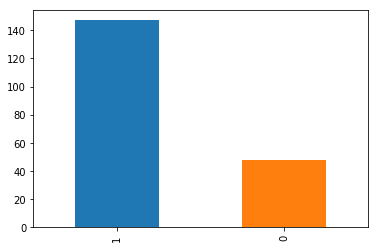

1    147
0     48
Name: status, dtype: int64
% clients with parkinsons 75.38461538461539


In [547]:
#Get the target column distribution.
pd.value_counts(parkinsonDF["status"]).plot(kind="bar")
plt.show()
parkingonData = pd.value_counts(parkinsonDF["status"])
print(pd.value_counts(parkinsonDF["status"]))
print("% clients with parkinsons", 100.0*parkingonData[1]/sum(parkingonData))

Summary about given data:
Totally 32 persons data is recorded. Of this only 8 persons data is with status - 0 [No parkinsons]. 24 persons have status - 1 [parkinsons]. There are 6 or 7 voice data of each person

# 3. Using univariate & bivariate analysis to check the individual attributes for their basic statistic such as central values, spread, tails etc. What are your observations? (15 points)

In [548]:
parkinsonDF.drop("name", axis=1, inplace=True)
parkinsonDF.drop("patientid", axis=1, inplace=True)

In [549]:
parkinsonDF.describe().transpose()

count        mean        std         min         25%  \
MDVP:Fo(Hz)       195.0  154.228641  41.390065   88.333000  117.572000   
MDVP:Fhi(Hz)      195.0  197.104918  91.491548  102.145000  134.862500   
MDVP:Flo(Hz)      195.0  116.324631  43.521413   65.476000   84.291000   
MDVP:Jitter(%)    195.0    0.006220   0.004848    0.001680    0.003460   
MDVP:Jitter(Abs)  195.0    0.000044   0.000035    0.000007    0.000020   
MDVP:RAP          195.0    0.003306   0.002968    0.000680    0.001660   
MDVP:PPQ          195.0    0.003446   0.002759    0.000920    0.001860   
Jitter:DDP        195.0    0.009920   0.008903    0.002040    0.004985   
MDVP:Shimmer      195.0    0.029709   0.018857    0.009540    0.016505   
MDVP:Shimmer(dB)  195.0    0.282251   0.194877    0.085000    0.148500   
Shimmer:APQ3      195.0    0.015664   0.010153    0.004550    0.008245   
Shimmer:APQ5      195.0    0.017878   0.012024    0.005700    0.009580   
MDVP:APQ          195.0    0.024081   0.016947    0.007190    0.013080   
Shimmer:DDA       195.0    0.046993   0.030459    0.013640    0.024735   
NHR               195.0    0.024847   0.040418    0.000650    0.005925   
HNR               195.0   21.885974   4.425764    8.441000   19.198000   
status            195.0    0.753846   0.431878    0.000000    1.000000   
RPDE              195.0    0.498536   0.103942    0.256570    0.421306   
DFA               195.0    0.718099   0.055336    0.574282    0.674758   
spread1           195.0   -5.684397   1.090208   -7.964984   -6.450096   
spread2           195.0    0.226510   0.083406    0.006274    0.174351   
D2                195.0    2.381826   0.382799    1.423287    2.099125   
PPE               195.0    0.206552   0.090119    0.044539    0.137451   

                         50%         75%         max  
MDVP:Fo(Hz)       148.790000  182.769000  260.105000  
MDVP:Fhi(Hz)      175.829000  224.205500  592.030000  
MDVP:Flo(Hz)      104.315000  140.018500  239.170000  
MDVP:Jitter(%)      0.004940    0.007365    0.033160  
MDVP:Jitter(Abs)    0.000030    0.000060    0.000260  
MDVP:RAP            0.002500    0.003835    0.021440  
MDVP:PPQ            0.002690    0.003955    0.019580  
Jitter:DDP          0.007490    0.011505    0.064330  
MDVP:Shimmer        0.022970    0.037885    0.119080  
MDVP:Shimmer(dB)    0.221000    0.350000    1.302000  
Shimmer:APQ3        0.012790    0.020265    0.056470  
Shimmer:APQ5        0.013470    0.022380    0.079400  
MDVP:APQ            0.018260    0.029400    0.137780  
Shimmer:DDA         0.038360    0.060795    0.169420  
NHR                 0.011660    0.025640    0.314820  
HNR                22.085000   25.075500   33.047000  
status              1.000000    1.000000    1.000000  
RPDE                0.495954    0.587562    0.685151  
DFA                 0.722254    0.761881    0.825288  
spread1            -5.720868   -5.046192   -2.434031  
spread2             0.218885    0.279234    0.450493  
D2                  2.361532    2.636456    3.671155  
PPE                 0.194052    0.252980    0.527367

Most features are have unique / non repeating values showcasing difference in each  

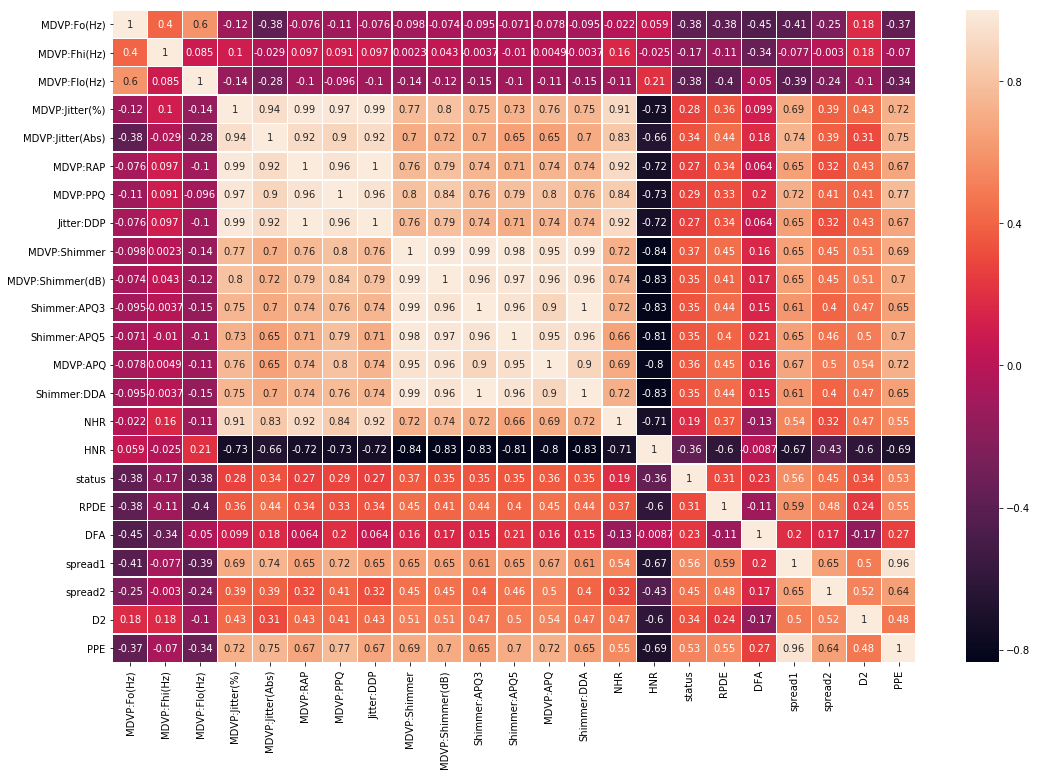

In [550]:
fig, ax = plt.subplots(figsize=(18, 12))         # Sample figsize in inches
sns.heatmap(parkinsonDF.corr(), annot=True, linewidths=.5, ax=ax)
plt.show()

There are many features that are correlating with each other. We can then rely on only one feature than adding 2 which dont differentiate much which will improve the model performance

0.9902755852458308


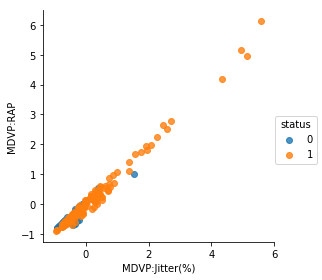

0.9742563864635716


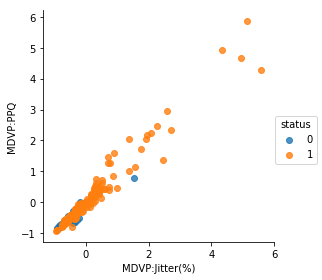

0.9902762153275696


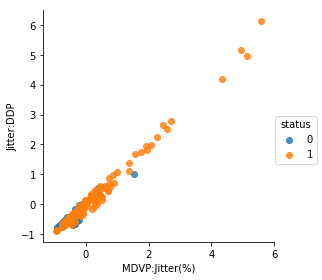

0.9573168930480008


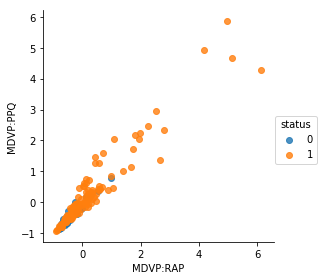

0.999999600104134


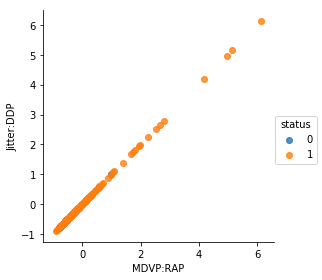

0.9573191582070278


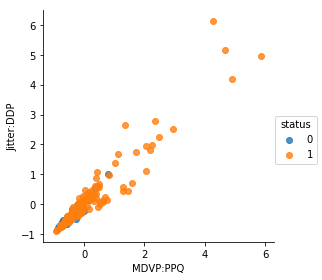

0.9872578145507641


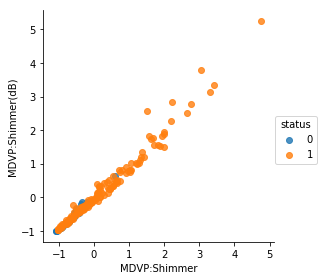

0.9876250519099836


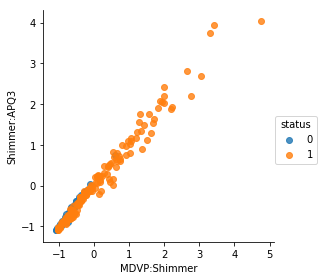

0.9828354477070599


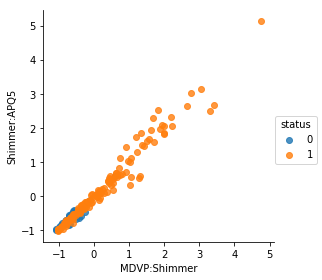

0.9500828933606194


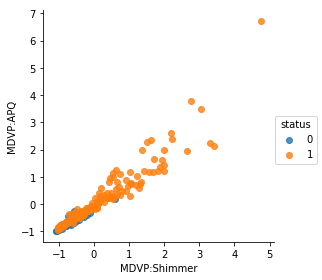

0.9876256527301991


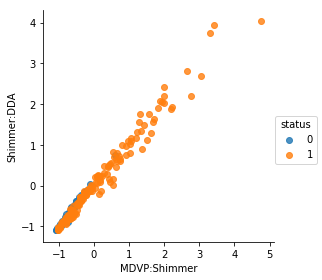

0.9631980852351485


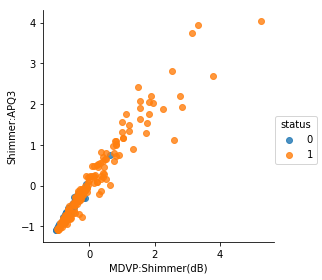

0.9737505606234651


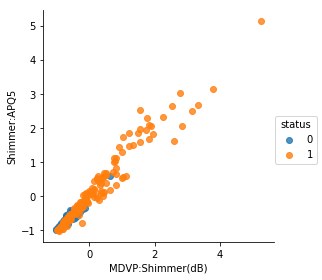

0.960976723296103


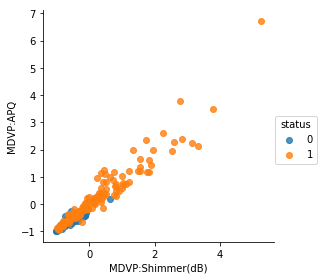

0.9632017037204208


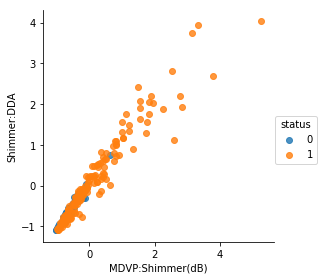

0.9600697638028982


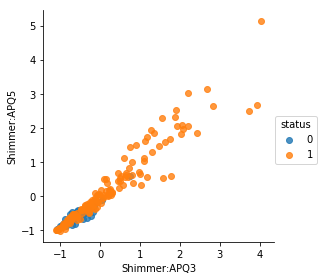

0.9999999636932829


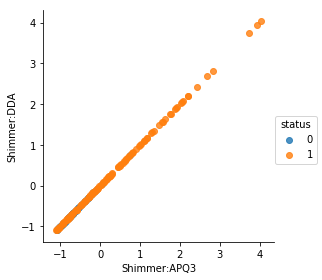

0.9600715928435876


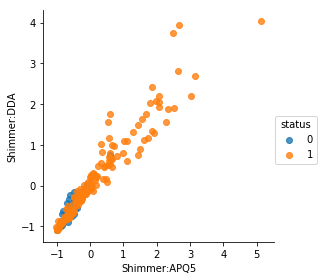

0.9624352932572803


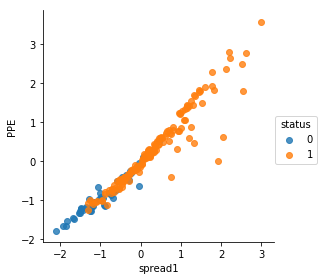

In [551]:
#just check which are having high coorelation - >= 0.95 along with status in pair plot and see if they can be dropped
corr = parkinsonDF.corr()
i = 0
colCount = corr.count()[0]
numCols = 0
while i < colCount:
    j = i + 1
    while j < colCount:
        if((corr.iloc[i, j] >= 0.95) & (i != j)):
            print(corr.iloc[i, j])
            sc = StandardScaler()
            df = pd.DataFrame(sc.fit_transform(parkinsonDF[[corr.columns[i], corr.columns[j]]]), columns=[corr.columns[i], corr.columns[j]])
            df["status"] = parkinsonDF["status"]
            sns.lmplot(corr.columns[i], corr.columns[j], df, hue="status", fit_reg=False, size=4)
            plt.show()
            numCols = numCols + 1
        j = j + 1
    i = i + 1

In [552]:
#drop all the high correlated features [>0.95]
out = (corr.mask(np.eye(len(corr), dtype=bool)).abs() >= 0.95).any()
out
dropCols = []
i = 0
while i < len(out):
    if(out[i]==True):
        dropCols.append(corr.columns[i])
    i = i +1
print("Following columns are dropped due to very high correlation", dropCols)
parkinsonDF.drop(dropCols, axis=1, inplace=True)

Following columns are dropped due to very high correlation ['MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'spread1', 'PPE']


In [553]:
#sns.pairplot(parkinsonDF, hue="status")
#plt.show()

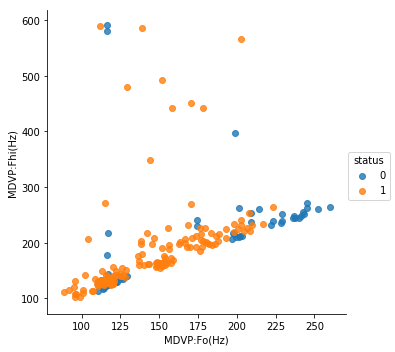

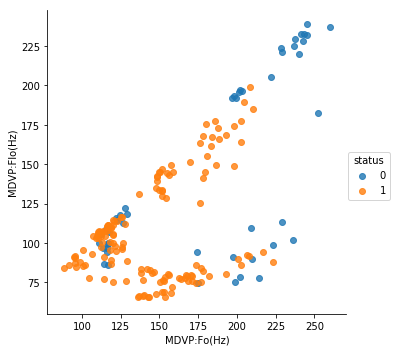

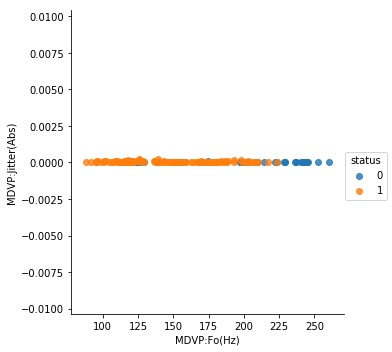

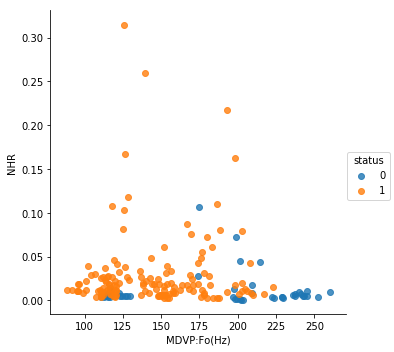

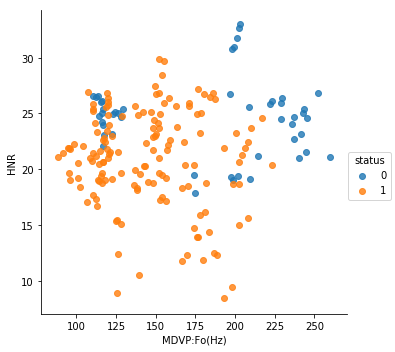

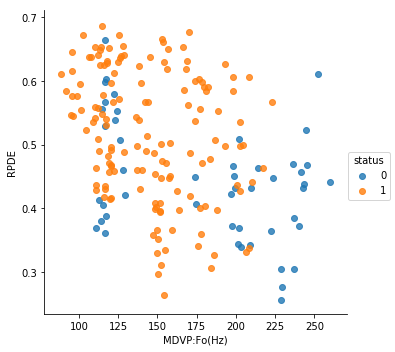

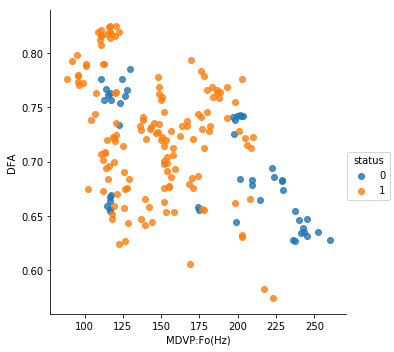

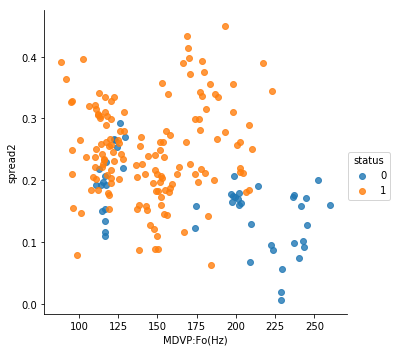

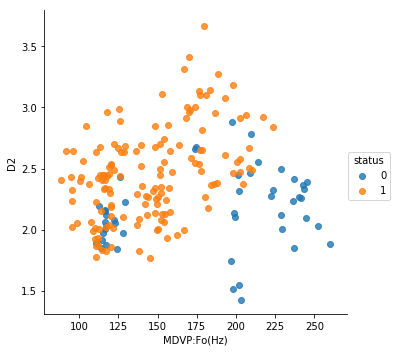

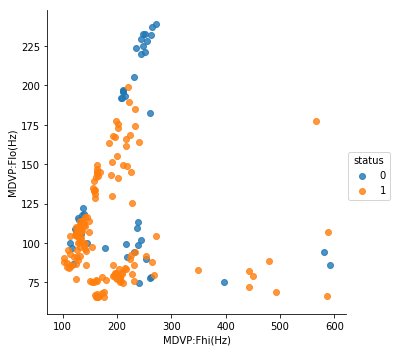

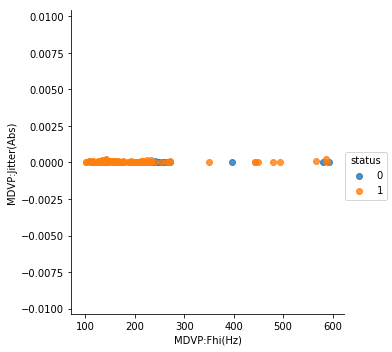

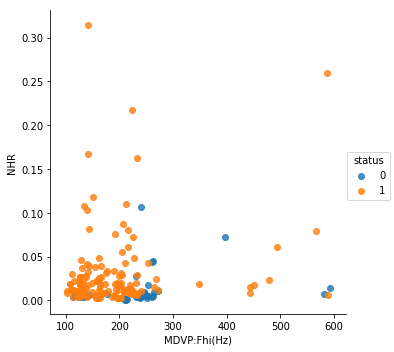

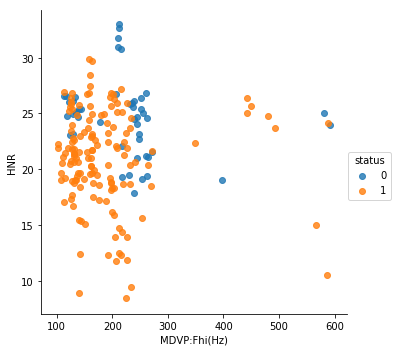

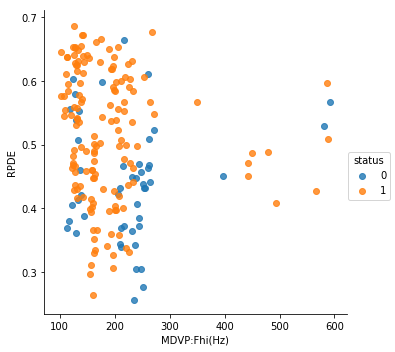

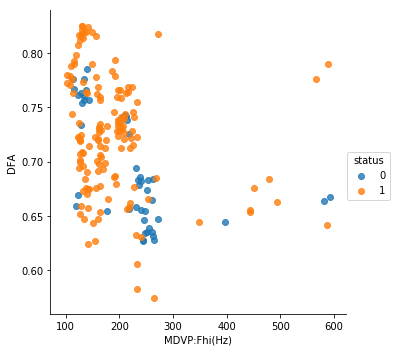

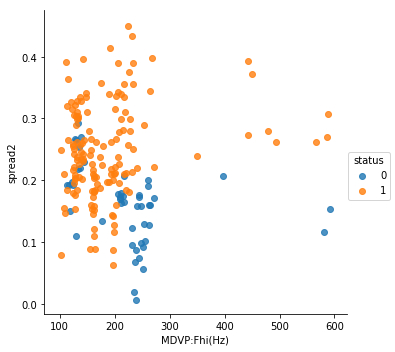

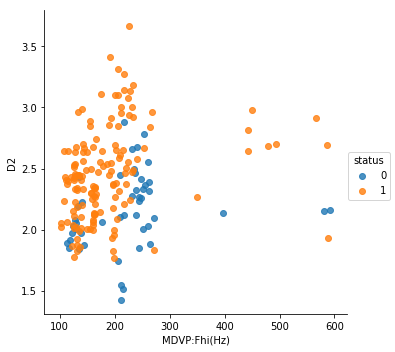

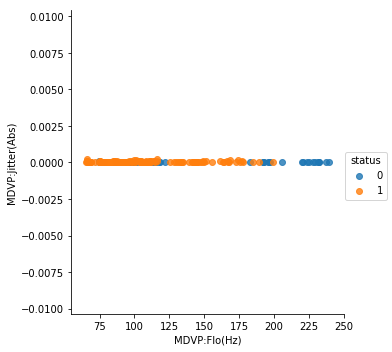

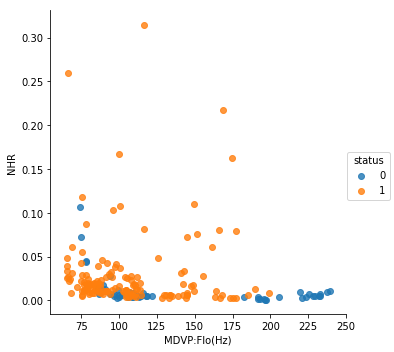

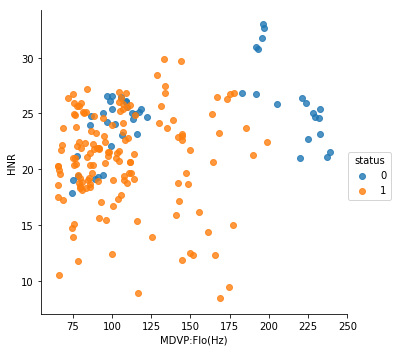

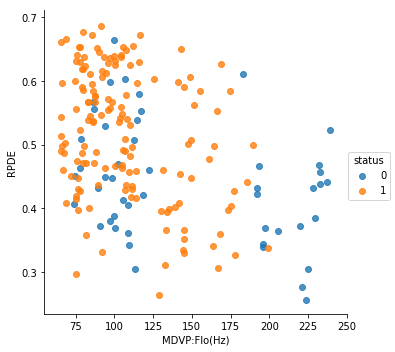

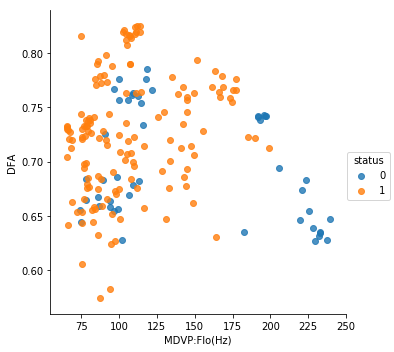

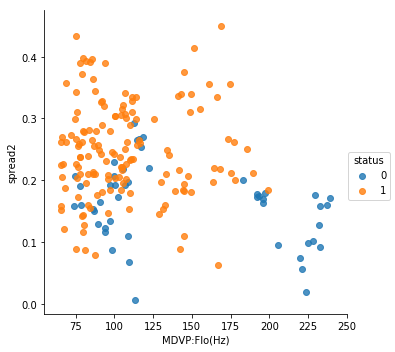

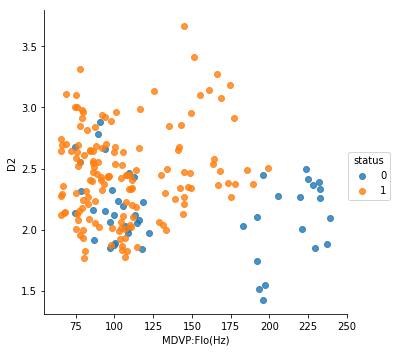

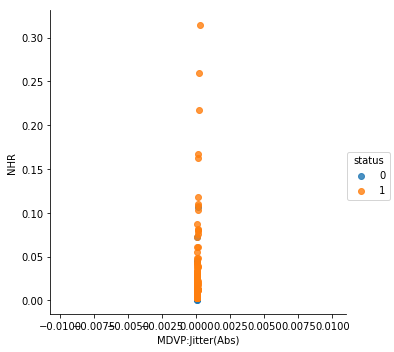

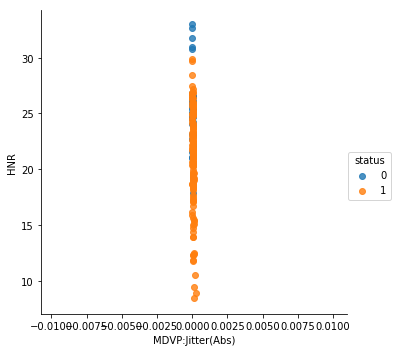

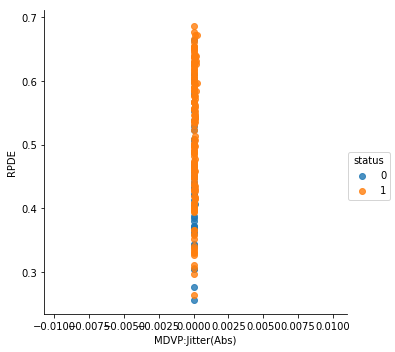

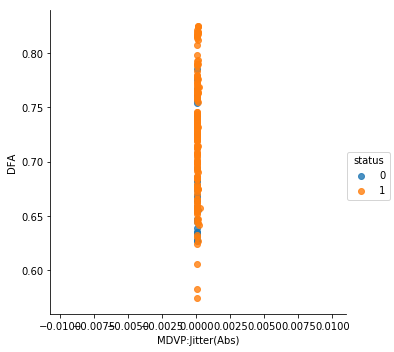

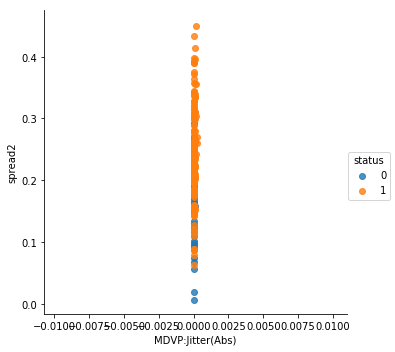

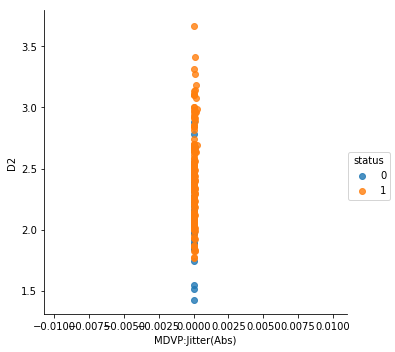

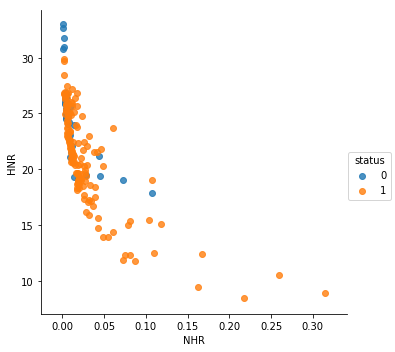

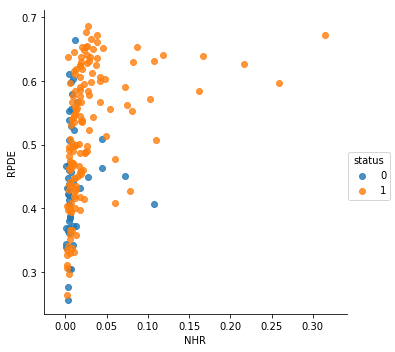

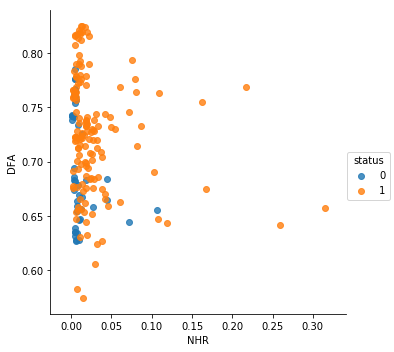

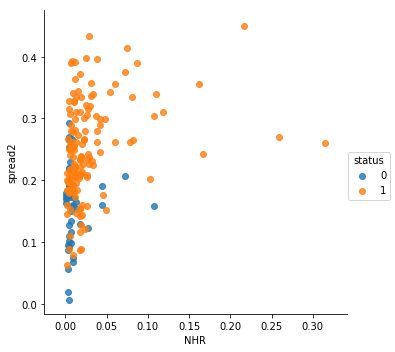

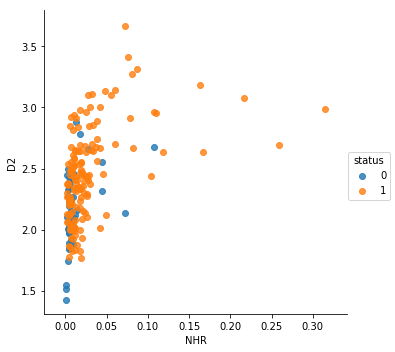

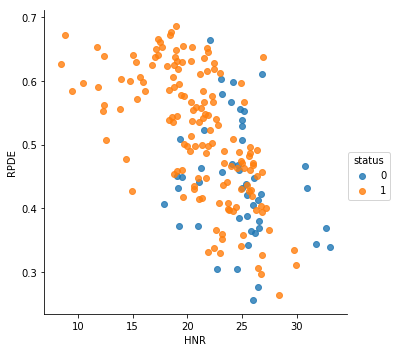

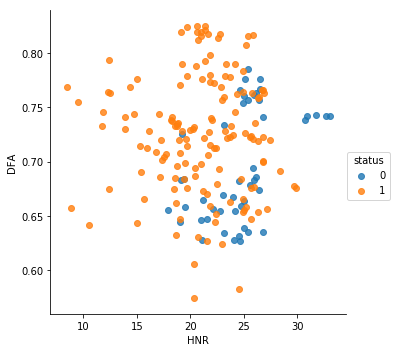

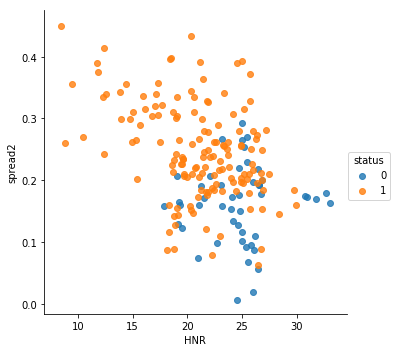

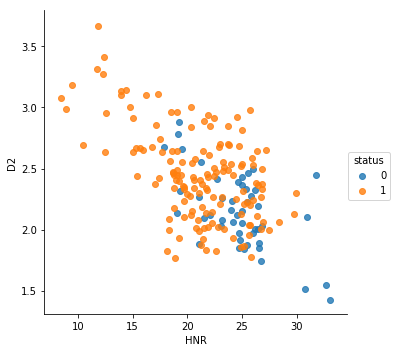

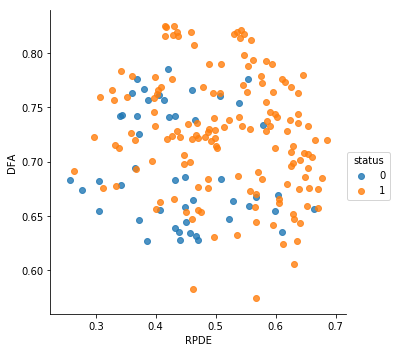

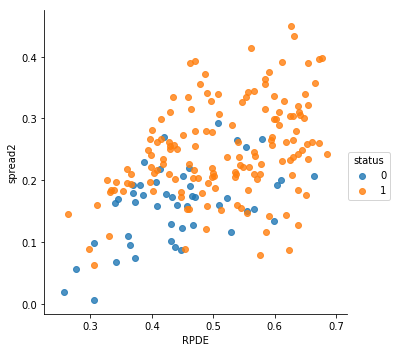

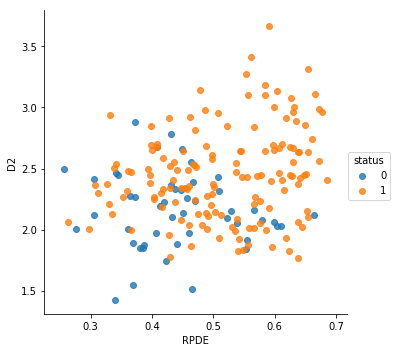

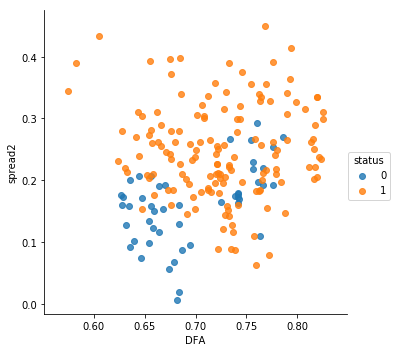

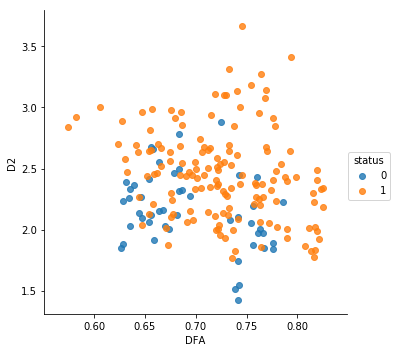

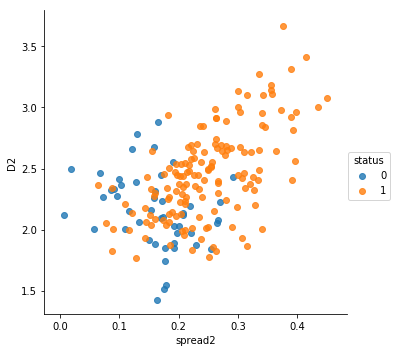

In [554]:
#pair plot done with each column paired to get better visibility for analysis
cols = parkinsonDF.columns
i = 0
while i < len(cols):
    j = i + 1
    while j < len(cols):
        if((cols[i] != "status") & (cols[j] != "status")):
            sns.lmplot(cols[i], cols[j], parkinsonDF, hue="status", fit_reg=False)
        j = j + 1
    i = i + 1

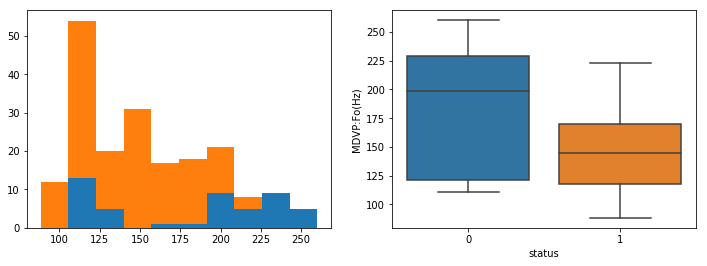

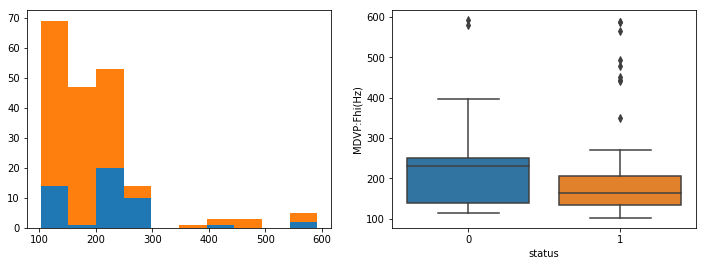

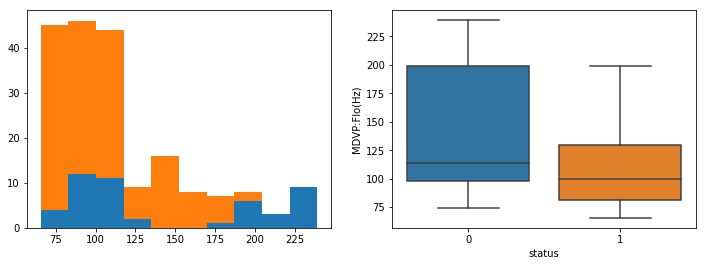

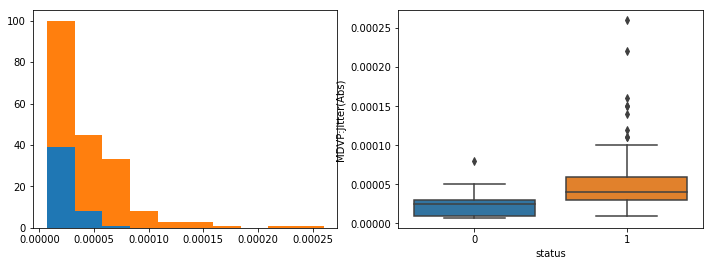

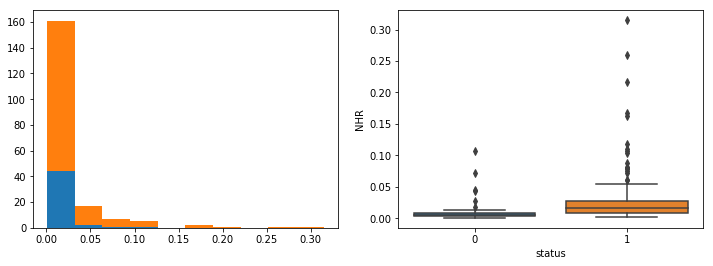

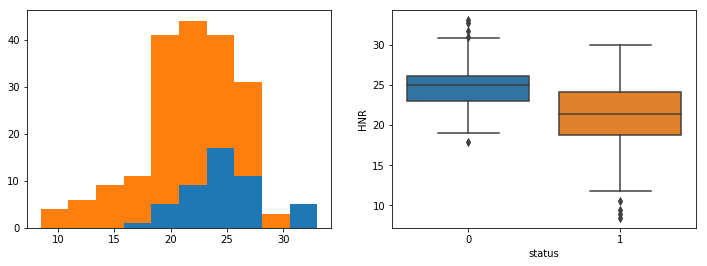

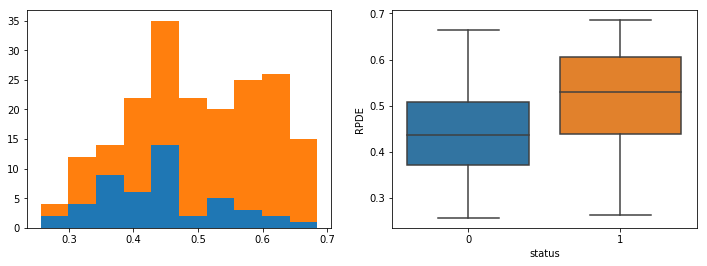

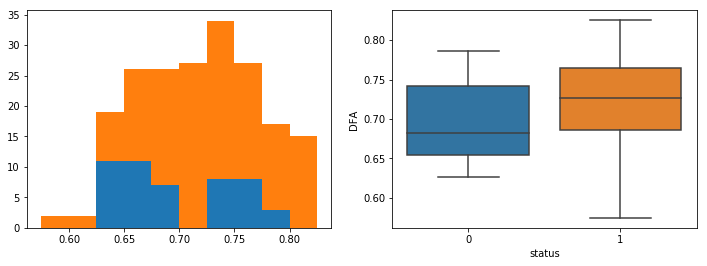

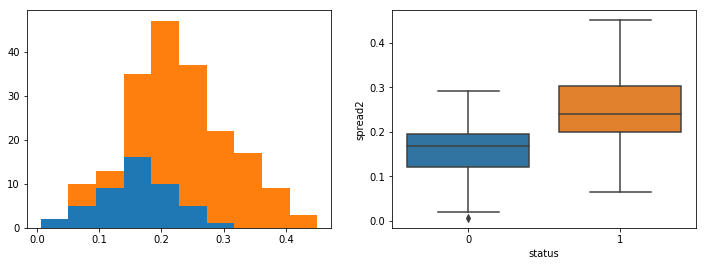

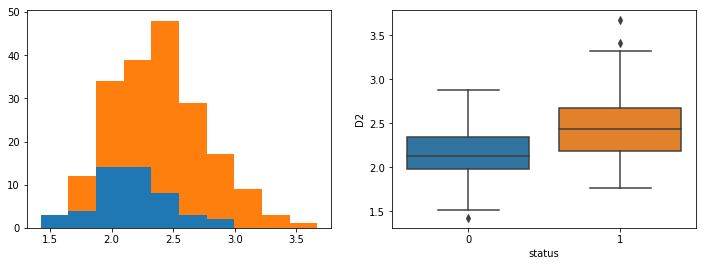

In [555]:
#perform univariate analysis
printHistAndBoxPlot(parkinsonDF, parkinsonDF.columns, "status")

Except for DFA, the remaining features do show potential to differentiate the status target variable

In [556]:
#Preparing Y - Feature to be learnt and then identified
Y = parkinsonDF["status"]
#Preparing X - All required columns except the identified Y & number which has no significance
X = parkinsonDF.drop(["status"],axis=1)
parkinsonDFBag = parkinsonDF.copy()
parkinsonDFBag.head()

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(Abs)      NHR     HNR  \
0      119.992       157.302        74.997           0.00007  0.02211  21.033   
1      122.400       148.650       113.819           0.00008  0.01929  19.085   
2      116.682       131.111       111.555           0.00009  0.01309  20.651   
3      116.676       137.871       111.366           0.00009  0.01353  20.644   
4      116.014       141.781       110.655           0.00011  0.01767  19.649   

   status      RPDE       DFA   spread2        D2  
0       1  0.414783  0.815285  0.266482  2.301442  
1       1  0.458359  0.819521  0.335590  2.486855  
2       1  0.429895  0.825288  0.311173  2.342259  
3       1  0.434969  0.819235  0.334147  2.405554  
4       1  0.417356  0.823484  0.234513  2.332180

# 4. Split the dataset into training and test set in the ratio of 70:30 (Training:Test).

In [557]:
#Split the data into training and test set in the ratio of 70:30 respectively
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30,random_state=5)

#Splitting with top 70% as training data and bottom 30% as testing data to ensure that all patients data does not get
#into the training data
#trainCount = int(Y.count()*0.7)
#testCount = Y.count()-trainCount
#X_train = X.head(trainCount)
#X_test = X.tail(testCount)
#y_train = Y.head(trainCount)
#y_test = Y.tail(testCount)
#print("Training data size:", trainCount)
#print("Testing  data size:", testCount)
print("With parkinsons -", y_train.sum()/y_train.count())
print("Without parkinsons -", 1 - (y_train.sum()/y_train.count()))

With parkinsons - 0.7647058823529411
Without parkinsons - 0.23529411764705888


In [558]:
#just as good practice use Standard Scaler to scale the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 5. Create the model using “entropy” method of reducing the entropy and fit it to training data. (5 points)

In [559]:
# invoking the decision tree classifier function. Using 'entropy' method of finding the split columns. 
dt_model = DecisionTreeClassifier(criterion = 'entropy', random_state=5)

In [560]:
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=5,
            splitter='best')

In [561]:
dt_model.feature_importances_
df = pd.DataFrame(dt_model.feature_importances_, columns = ["FeatureImportance"], index = X.columns)
df.sort_values("FeatureImportance", ascending=False)

FeatureImportance
MDVP:Flo(Hz)               0.261685
spread2                    0.225385
MDVP:Fo(Hz)                0.210669
MDVP:Fhi(Hz)               0.134535
RPDE                       0.055116
NHR                        0.048922
D2                         0.045005
MDVP:Jitter(Abs)           0.018683
HNR                        0.000000
DFA                        0.000000

# 6. Test the model on test data and what is the accuracy achieved. Capture the predicted values and do a crosstab. (7.5 points)

In [562]:
print("Training accuracy", dt_model.score(X_train , y_train))
print("Testing accuracy", dt_model.score(X_test , y_test))
y_pred = dt_model.predict(X_test)
confusion_matrix_dt = metrics.confusion_matrix(y_test, y_pred)
printConfusionMatrixAndAccuracy("Decision Tree with regularization", confusion_matrix_dt)

Training accuracy 1.0
Testing accuracy 0.847457627118644
Confusion matrix -  Decision Tree with regularization
[[11  5]
 [ 4 39]]
Analysis of confusion matrix
True positive: correctly predicted as no parkinsons -  11
True negative: correctly predicted as parkinsons -  39
False positive: wrongly predicted as parkinsons -  5
False negative: wrongly predicted as no parkinsons -  4


# 7. Use regularization parameters of max_depth, min_sample_leaf to recreate the model. What is the impact on the model accuracy? How does regularization help? (20 points)

In [563]:
#Just check the status count to set the class weights correctly
print(y_train.sum()/y_train.count(), 1 - (y_train.sum()/y_train.count()))

0.7647058823529411 0.23529411764705888


In [564]:
dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_leaf=2, random_state=5, class_weight={0:.2, 1:.8})

In [565]:
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, criterion='entropy',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=5,
            splitter='best')

In [566]:
print(dt_model.score(X_train , y_train))
print(dt_model.score(X_test , y_test))
y_pred = dt_model.predict(X_test)
confusion_matrix_dt = metrics.confusion_matrix(y_test, y_pred)
printConfusionMatrixAndAccuracy("Decision Tree with regularization", confusion_matrix_dt)

0.9705882352941176
0.8813559322033898
Confusion matrix -  Decision Tree with regularization
[[11  5]
 [ 2 41]]
Analysis of confusion matrix
True positive: correctly predicted as no parkinsons -  11
True negative: correctly predicted as parkinsons -  41
False positive: wrongly predicted as parkinsons -  5
False negative: wrongly predicted as no parkinsons -  2


In [567]:
# In the following lines, we call the bagging classifer with oob_score (out of bag score) set to true which false by default
# This makes the baggingclassifier use the 37% unused data for testing
# Compare the performance of the BGCL with regularized dt above. 
dt_model = DecisionTreeClassifier(criterion = 'entropy', random_state=5)
from sklearn.ensemble import BaggingClassifier
bgcl = BaggingClassifier(base_estimator=dt_model, n_estimators=50, random_state=5)
bgcl = bgcl.fit(X_train, y_train)

In [568]:
print(bgcl.score(X_train , y_train))
print(bgcl.score(X_test , y_test))
y_pred = bgcl.predict(X_test)
confusion_matrix_dt = metrics.confusion_matrix(y_test, y_pred)
printConfusionMatrixAndAccuracy("Bagging classifier", confusion_matrix_dt)

1.0
0.9322033898305084
Confusion matrix -  Bagging classifier
[[13  3]
 [ 1 42]]
Analysis of confusion matrix
True positive: correctly predicted as no parkinsons -  13
True negative: correctly predicted as parkinsons -  42
False positive: wrongly predicted as parkinsons -  3
False negative: wrongly predicted as no parkinsons -  1


Regularization helps in reducing overfitting the model and optimizing the algorithm and tuning the right hyper parameters to achieve best model performance in the given data. It is seen here that it helps in improving the performance of the model

# 8. Next implement the decision tree using Random Forest. What is the optimal number of trees that gives the best result? (10 points)

In [569]:
from sklearn.ensemble import RandomForestClassifier

In [570]:
#use the same data X, Y - Train and Test for the operation
depthValues = np.arange(2, 25)
#declare the array for noting down the accuracy
train_accuracy_plot = np.empty(len(depthValues))
test_accuracy_plot = np.empty(len(depthValues))

rfcl = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state=5)
rfcl = rfcl.fit(X_train, y_train)
print("Depth = None", "Train score -", rfcl.score(X_train, y_train), "Test score -", rfcl.score(X_test, y_test))
    
i = 0    
for depth in depthValues:
    rfcl = RandomForestClassifier(n_estimators = 100, criterion="entropy", max_depth=depth, random_state=5)
    rfcl = rfcl.fit(X_train, y_train)
    train_accuracy_plot[i] = rfcl.score(X_train, y_train)
    test_accuracy_plot[i] = rfcl.score(X_test, y_test)
    print("Depth =", depth, "Train score -", rfcl.score(X_train, y_train), "Test score -", rfcl.score(X_test, y_test))
    i = i + 1

Depth = None Train score - 1.0 Test score - 0.9491525423728814
Depth = 2 Train score - 0.8823529411764706 Test score - 0.847457627118644
Depth = 3 Train score - 0.9191176470588235 Test score - 0.864406779661017
Depth = 4 Train score - 0.9705882352941176 Test score - 0.8983050847457628
Depth = 5 Train score - 1.0 Test score - 0.9322033898305084
Depth = 6 Train score - 1.0 Test score - 0.9491525423728814
Depth = 7 Train score - 1.0 Test score - 0.9491525423728814
Depth = 8 Train score - 1.0 Test score - 0.9491525423728814
Depth = 9 Train score - 1.0 Test score - 0.9491525423728814
Depth = 10 Train score - 1.0 Test score - 0.9491525423728814
Depth = 11 Train score - 1.0 Test score - 0.9491525423728814
Depth = 12 Train score - 1.0 Test score - 0.9491525423728814
Depth = 13 Train score - 1.0 Test score - 0.9491525423728814
Depth = 14 Train score - 1.0 Test score - 0.9491525423728814
Depth = 15 Train score - 1.0 Test score - 0.9491525423728814
Depth = 16 Train score - 1.0 Test score - 0.9491

In [571]:
rfcl = RandomForestClassifier(n_estimators = 100, criterion="entropy", max_depth=6, random_state=5)
rfcl = rfcl.fit(X_train, y_train)

In [572]:
print(rfcl.score(X_train , y_train))
print(rfcl.score(X_test , y_test))
y_pred = rfcl.predict(X_test)
confusion_matrix_dt = metrics.confusion_matrix(y_test, y_pred)
printConfusionMatrixAndAccuracy("Random Forest", confusion_matrix_dt)

1.0
0.9491525423728814
Confusion matrix -  Random Forest
[[13  3]
 [ 0 43]]
Analysis of confusion matrix
True positive: correctly predicted as no parkinsons -  13
True negative: correctly predicted as parkinsons -  43
False positive: wrongly predicted as parkinsons -  3
False negative: wrongly predicted as no parkinsons -  0


Optimal number of trees chosen is 6. With this False negative is completely elliminated. Most important in this case study.
It is also clear that Random forest has the best performance of all models

It is also noted that the data points are too low. If the split is done based on head representing 70% and tail representing 30%, the performance is not similar. 